## Import standard libraries

In [4]:
# Import custom libraries from local folder.
from importlib import reload

# Import nn module from torch to replicate kessler tool
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get current working directory path for the tool parent folder and print it.
from pathlib import Path
import os
parent_folder = 'scapy'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))

# Import sys library to import libraries from parent folders
import sys
sys.path.append(cwd)

# Import utils library containing miscellaneous functions/classes
from scapy import utils
from scapy.ccsds import format_json

# Import SCALIB modules for NN development
import scapy.cre as cre            # NN models
import scapy.utils as utils
import scapy.data as data
import scapy.ccsds as ccsds

# Set overall seed for reproducibility
utils.seed(1)

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rc

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in utils.cwd:
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    
# Get current working directory path for the tool parent folder and print it.
print('Parent working directory: %s' % utils.cwd)


Parent working directory: /Users/jjrr/Documents/SCA-Project/scapy


## Import training dataset

In [176]:
# Import library to import Kelvins challlenge data
from scapy.data import kelvins_challenge_events

# Import Kelvins dataset and convert it to dataframes in CCSDS format
datasets = {}
for filename in ['test_data.csv', 'train_data.csv']:
    label = filename.split('_')[0]

    filepath_dest = os.path.join(utils.cwd,'data','ccsds', filename)
    filepath_orig = os.path.join(utils.cwd,'data','esa-challenge', filename)

    if os.path.exists(filepath_dest):
        datasets[label] = pd.read_csv(filepath_dest, index_col=0)
    else:

        # Get ConjunctionEventsDataset object 
        events = kelvins_challenge_events(filepath_orig,
                    drop_features = ['c_rcs_estimate', 't_rcs_estimate'],
                    num_events = 2000)

        # Convert Conjunction Events Dataset to pandas DataFrame and save it.
        datasets[label] = events.to_dataframe(event_id=True)
        datasets[label].to_csv(filepath_dest)
        
    datasets[label] = datasets[label].astype(ccsds.df_dtype_conversion)

In [173]:
from sklearn.utils.class_weight import compute_class_weight

def get_classes(df_input:pd.DataFrame, feature:str='COLLISION_PROBABILITY', 
                threshold:float=-4):

    # Create new column with the collision risk threshold flag
    df = df_input.copy()
    df['COLLISION_FLAG'] = df[[feature]]>=threshold

    # Get dummies columns
    dummies = pd.get_dummies(df['COLLISION_FLAG'], dtype=int) \
            .rename(columns={0: 'COLLISION_FALSE',
                             1: 'COLLISION_TRUE'})

    df = df.join(dummies)
    new_features = list(dummies.columns)
    outputs = df['COLLISION_FLAG'].to_numpy()
    class_weights = torch.tensor(compute_class_weight(
                                    class_weight='balanced',
                                    classes = np.unique(outputs),
                                    y = outputs),
                                    dtype=torch.float)
    
    return df, new_features, class_weights

In [177]:
reload(ccsds)

# Get list of obligatory features.
input_features = ccsds.get_features(only_names=True, include_object_preffix=True, 
                            **dict(obligatory=True, dtype=['float','category']))

# Segregate numerical from categorical features
input_features += ['OBJECT1_OBJECT_TYPE', 'OBJECT2_OBJECT_TYPE']
input_features = list(map(lambda x: x.replace('TCA', '__DAYS_TO_TCA'), input_features))

output_features = ['COLLISION_PROBABILITY']

datasets['train'], output_features_class, class_weights = get_classes(df_input=datasets['train'])
datasets['test'], _, _ = get_classes(df_input=datasets['test'])

print(f'Output features for regression: {output_features}')
print(f'Output features for classification: {output_features_class}')
display(datasets['train'].head(5))



Output features for regression: ['COLLISION_PROBABILITY']
Output features for classification: ['COLLISION_FALSE', 'COLLISION_TRUE']


,CCSDS_CDM_VERS,CREATION_DATE,ORIGINATOR,MESSAGE_FOR,MESSAGE_ID,TCA,MISS_DISTANCE,RELATIVE_SPEED,RELATIVE_POSITION_R,RELATIVE_POSITION_T,...,OBJECT2_CTHR_THR,__MAX_RISK_ESTIMATE,__MAX_RISK_SCALING,__CREATION_DATE,__TCA,__DAYS_TO_TCA,__EVENT_ID,COLLISION_FLAG,COLLISION_FALSE,COLLISION_TRUE
0,1.0,2023-09-20 07:30:55.604684,<NA>,<NA>,<NA>,2023-09-21 21:07:06.971684,14923.0,13792.0,453.8,5976.6,...,NaN,-7.834756,8.602101,0.000000,1.566798,1.566798,0,False,1,0
1,1.0,2023-09-20 16:08:19.532684,<NA>,<NA>,<NA>,2023-09-21 21:07:06.971684,14544.0,13792.0,474.3,5821.2,...,NaN,-7.848937,8.956374,0.359305,1.566798,1.207494,0,False,1,0
2,1.0,2023-09-20 22:15:57.518684,<NA>,<NA>,<NA>,2023-09-21 21:07:06.971684,14475.0,13792.0,474.6,5796.2,...,NaN,-7.847406,8.932195,0.614605,1.566798,0.952193,0,False,1,0
3,1.0,2023-09-21 07:12:23.538684,<NA>,<NA>,<NA>,2023-09-21 21:07:06.971684,14579.0,13792.0,472.7,5838.9,...,NaN,-7.845880,8.913444,0.987129,1.566798,0.579669,0,False,1,0
4,1.0,2023-09-21 14:55:52.529684,<NA>,<NA>,<NA>,2023-09-21 21:07:06.971684,14510.0,13792.0,478.7,5811.1,...,NaN,-7.852942,9.036838,1.308992,1.566798,0.257806,0,False,1,0


## Aritificial Neural Network model for Collision Risk Probability Estimation (CRPE)

#### Embedding categorical input features

An embedding is a vector representation of a categorical variable. The representation of this vector is computed through the use of NN models/techniques that take into account potential relation between categories in order to create the vector representation for each category.

In practice, an embedding matrix is a lookup table for a vector. Each row of an embedding matrix is a vector for a unique category.

The main advantadge of using embeddings instead of One Hot/Dummy Encoding techniques (one column per unique value of categorical feature with 0s and 1s) is that it can preserve the natural order and common relationships between the categorical features. For example, we could represent the days of the week with 4 floating-point numbers each, and two consecutive days would look more similar than two weekdays that are days apart from each other.


The rule of thumb for determining the embedding size (number of elemens per array) is to divide the number of unique entries in each column by 2, but not to exceed 50.

### Classification model

In [180]:
reload(cre)

# Initialise dictionary to store the TensorDatasets objects
c_dataobjects = {}

# Get objects for training and test
for label, df in datasets.items():

    c_dataobjects[label] = data.TensorDatasetFromDataFrame(df,
                                input_features = input_features, 
                                output_features = output_features_class)
    print(f'{label.upper():>6}: {c_dataobjects[label]}')

# Define the layers of the network
layers = [200, 200, 100]
act_functions = nn.ReLU()

# Initialise CRPE model
c_model = cre.model( input_size = c_dataobjects['train'].input_size, 
                     output_size = c_dataobjects['train'].output_size, 
                     layers = layers,
                     act_functions = act_functions,
                     dropout_probs = 0.2,
                     classification=True,
                     class_weights = class_weights)

# Get filepath for the model and print it 
af_label = act_functions[0] if isinstance(act_functions,list) else act_functions 
af_label = f'{str(af_label).split("(")[0].lower()}'

filename = f'cre_{"-".join([str(l) for l in layers])}_{af_label}'

# filename = f'crpe_l{"_l".join([str(l) for l in layers])}'
filepath = os.path.join(utils.cwd, 'models', 'parameters', 'cre', 
                        f'{filename}_classification_parameters.pt')

# Print filepath where the model is going to be saved
print(f'\nFilepath: {filepath}\n')

# Print structure of the model
print(c_model)

  TEST: TensorDatasetFromDataFrame(Inputs: 47 | Outputs: 2 | Entries: 19531)
 TRAIN: TensorDatasetFromDataFrame(Inputs: 47 | Outputs: 2 | Entries: 127037)

Filepath: /Users/jjrr/Documents/SCA-Project/scalib/models/crpe_200-200-100_relu_classification_parameters.pt

CollisionRiskProbabilityEstimator(
  (_act_functions): ReLU()
  (model): ModuleList(
    (0): Linear(in_features=47, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=200, out_features=100, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_feature

In [185]:
# Train classification model
c_model.learn(data = c_dataobjects['train'].data, epochs = 3, lr = 1e-4, 
              batch_size = 1000, device = 'cpu', epoch_step_checkpoint = 2, 
              filepath=filepath)

Number of learnable parameters of the model: 71,102

Model parameters loaded from /Users/jjrr/Documents/SCA-Project/scalib/models/crpe_200-200-100_relu_classification_parameters.pt
 - Total epochs       = 6
 - Total iterations   = 648
 - Validation loss    = 3.1711e-01
 - Last learning rate = 1.0000e-03


TRAINING COLLISION RISK PROBABILITY ESTIMATOR MODEL:
| Progress                   |    Time     | Iters/sec | Comments
| 100% |██████████| (324/324)| 00h:14m:06s |   0.38    | E(3/3) B(108/108) | Loss > T(2.2095e-01) V(2.8322e-01)

Saving model parameters ... Done.


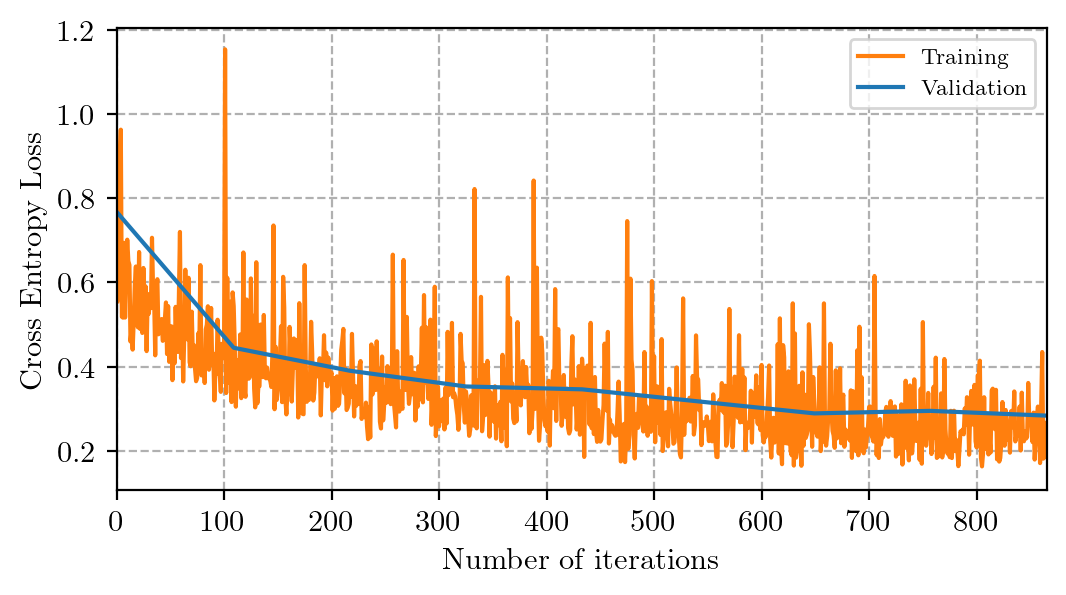

In [186]:
# Plot loss
c_model.plot_loss()

In [187]:
# Get results from testing
test_results = c_model.test(data_test = c_dataobjects['test'].data,test_batch_size=2000)

In [192]:
df_metric =pd.DataFrame.from_dict(data = test_results, orient='columns')
display(df_metric)

# Transpose DataFrame and rename columns
df_metric = df_metric.describe()
df_metric = df_metric.rename(index={'50%':f'median'})
df_metric = df_metric.transpose()[['mean', 'std', 'median']]
display(df_metric)


,tp,fn,fp,tn,accuracy,precision,recall,f1,aucroc
0,15.0,7.0,328.0,1650.0,83.250000,4.373178,68.181818,8.219178,0.757997
1,8.0,6.0,343.0,1643.0,82.550000,2.279202,57.142857,4.383562,0.699360
2,10.0,10.0,363.0,1617.0,81.350000,2.680965,50.000000,5.089059,0.658333
3,9.0,8.0,358.0,1625.0,81.700000,2.452316,52.941176,4.687500,0.674439
4,15.0,5.0,333.0,1647.0,83.100000,4.310345,75.000000,8.152174,0.790909
5,13.0,9.0,340.0,1638.0,82.550000,3.682720,59.090909,6.933333,0.709509
6,18.0,4.0,361.0,1617.0,81.750000,4.749340,81.818182,8.977556,0.817837
7,17.0,15.0,335.0,1633.0,82.500000,4.829545,53.125000,8.854167,0.680513
8,15.0,5.0,342.0,1638.0,82.650000,4.201681,75.000000,7.957560,0.788636
9,8.0,3.0,266.0,1254.0,82.429784,2.919708,72.727273,5.614035,0.776136


,tp,fn,fp,tn,accuracy,precision,recall,f1,aucroc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,12.800000,7.200000,336.900000,1596.200000,82.382978,3.647900,64.502722,6.886812,0.735367
std,3.765339,3.521363,27.698576,120.788888,0.609461,0.980373,11.344583,1.786425,0.057270
min,8.000000,3.000000,266.000000,1254.000000,81.350000,2.279202,50.000000,4.383562,0.658333
25%,9.250000,5.000000,333.500000,1619.000000,81.919946,2.740651,54.129464,5.220303,0.685225
median,14.000000,6.500000,341.000000,1635.500000,82.525000,3.942200,63.636364,7.445447,0.733753
75%,15.000000,8.750000,354.250000,1641.750000,82.625000,4.357470,74.431818,8.202427,0.785511
max,18.000000,15.000000,363.000000,1650.000000,83.250000,4.829545,81.818182,8.977556,0.817837


,mean,std,median
tp,12.800000,3.765339,14.000000
fn,7.200000,3.521363,6.500000
fp,336.900000,27.698576,341.000000
tn,1596.200000,120.788888,1635.500000
accuracy,82.382978,0.609461,82.525000
precision,3.647900,0.980373,3.942200
recall,64.502722,11.344583,63.636364
f1,6.886812,1.786425,7.445447
aucroc,0.735367,0.057270,0.733753


In [210]:
all = sum(df_metric.loc['tp':'tn','mean'])
tp, fn, fp, tn = tuple(df_metric.loc['tp':'tn','mean'].values)

print(f'Confusion matrix:\n'
      f'TP: {tp/(tp + fn)*100:^2.2f}% ({tp}) FP: {fp/(fp + tn)*100:^2.2f}% ({fp})\n'
      f'FN: {fn/(tp + fn)*100:^2.2f}% ({fn}) TN: {tn/(fp + tn)*100:^2.2f}% ({tn})')

Confusion matrix:
TP: 64.00% (12.8) FP: 17.43% (336.9)
FN: 36.00% (7.2) TN: 82.57% (1596.2)


### Regression model

In [193]:
reload(cre)

# Initialise dictionary to store the TensorDatasets objects
r_dataobjects = {}

# Get objects for training and test
for label, df in datasets.items():

    r_dataobjects[label] = data.TensorDatasetFromDataFrame(df,
                                input_features = input_features, 
                                output_features = output_features)
    
    print(f'{label.upper():>6}: {r_dataobjects[label]}')

# Define the layers of the network
layers = [200, 200, 100]
act_functions = nn.ReLU()

# Initialise CRPE model
r_model = cre.model( input_size = r_dataobjects['train'].input_size, 
                     output_size = r_dataobjects['train'].output_size, 
                     layers = layers,
                     act_functions = act_functions,
                     dropout_probs = 0.2)

# Get filepath for the model and print it 
af_label = act_functions[0] if isinstance(act_functions,list) else act_functions 
af_label = f'{str(af_label).split("(")[0].lower()}'

filename = f'crpe_{"-".join([str(l) for l in layers])}_{af_label}'

# filename = f'crpe_l{"_l".join([str(l) for l in layers])}'
filepath = os.path.join(utils.cwd, 'models', 'parameters', 'cre', 
                        f'{filename}_regression_parameters.pt')

# Print filepath where the model is going to be saved
print(filepath)

# Print structure of the model
print(r_model)

  TEST: TensorDatasetFromDataFrame(Inputs: 47 | Outputs: 1 | Entries: 19531)
 TRAIN: TensorDatasetFromDataFrame(Inputs: 47 | Outputs: 1 | Entries: 127037)
/Users/jjrr/Documents/SCA-Project/scalib/models/crpe_200-200-100_relu_regression_parameters.pt
CollisionRiskProbabilityEstimator(
  (_act_functions): ReLU()
  (model): ModuleList(
    (0): Linear(in_features=47, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=200, out_features=100, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=100, out_featu

Number of learnable parameters of the model: 71,001

TRAINING COLLISION RISK PROBABILITY ESTIMATOR MODEL:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (1080/1080)| 00h:53m:41s |   0.34    | E(10/10) B(108/108) | Loss > T(4.0675e+01) V(4.0423e+01)

Saving model parameters ... Done.


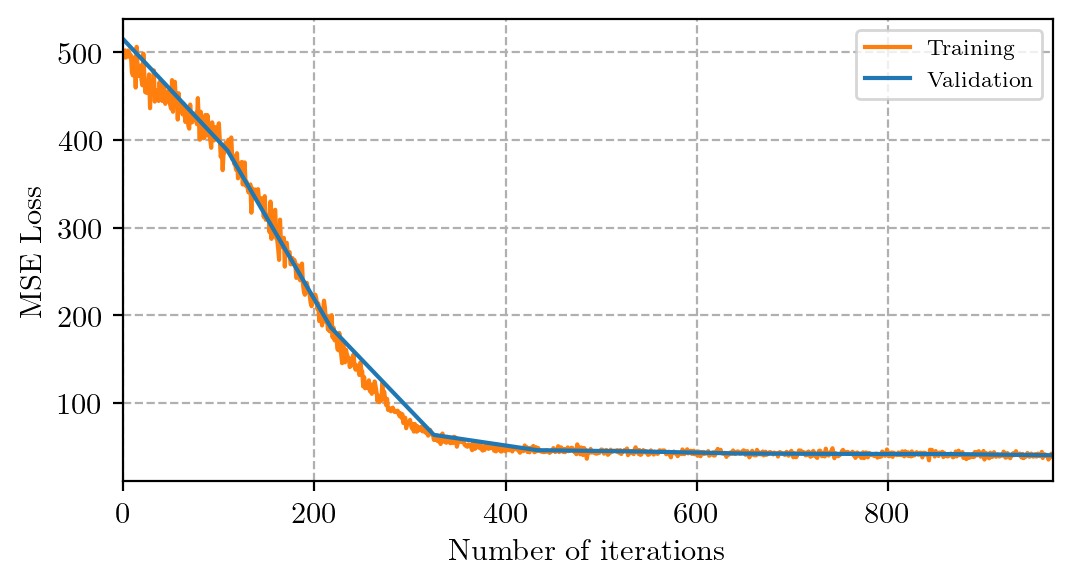

In [194]:
# Train classification model
r_model.learn(data = r_dataobjects['train'].data, epochs = 10, lr = 1e-3, 
              batch_size = 1000, device = 'cpu', epoch_step_checkpoint = 2, 
              filepath = filepath)

# Plot loss
r_model.plot_loss()

In [ ]:
# Get results from testing
r_test_results = r_model.test(data_test = r_dataobjects['test'].data,test_batch_size=2000)

In [215]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import f1_score as f1
from sklearn.metrics import roc_auc_score as auc_roc

# Get the collision risk probabilities from the model and the test dataset
r_test_data = r_dataobjects['test'].data
y_pred = r_model.forward(r_test_data.inputs).detach().numpy().flatten()
y_true = r_test_data.outputs.detach().numpy().flatten()

# Define risk threshold for collision avoidance manouvre.
risk_threshold = -4.0

# Evaluate accuracy using the confusion matrix.
y_true = y_true >= risk_threshold
y_pred = y_pred >= risk_threshold

# Get the values from the confusion matrix.
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print(f'Classification scores:\n'
      f' - Accuracy  = {accuracy(y_true, y_pred)*100:5.2f}%\n'
      f' - Precision = {precision(y_true, y_pred)*100:5.2f}%\n'
      f' - Recall    = {recall(y_true, y_pred)*100:5.2f}%\n'
      f' - F1 score  = {f1(y_true, y_pred)*100:5.2f}%\n'
      f' - AUC-ROC   = {auc_roc(y_true, y_pred):6.3f}\n')

print(f'Confusion matrix:\n'
      f'TP: {tp/(tp + fn)*100:^2.2f}% ({tp}) FP: {fp/(fp + tn)*100:^2.2f}% ({fp})\n'
      f'FN: {fn/(tp + fn)*100:^2.2f}% ({fn}) TN: {tn/(fp + tn)*100:^2.2f}% ({tn})')

Classification scores:
 - Accuracy  = 98.19%
 - Precision =  1.89%
 - Recall    =  1.50%
 - F1 score  =  1.67%
 - AUC-ROC   =  0.503

Confusion matrix:
TP: 1.50% (3) FP: 0.81% (156)
FN: 98.50% (197) TN: 99.19% (19175)
